This small project builds a small chatbot using end-to-end memory network.
Read the reseach paper that this model is based on https://arxiv.org/pdf/1503.08895.pdf

# Import data and simple exploration 

In [3]:
import pickle
import numpy as np

In [4]:
# import data
with open("train_qa.txt", "rb") as f:
    train_data = pickle.load(f)

with open("test_qa.txt", "rb") as f:
    test_data = pickle.load(f)

In [12]:
# training data is a list with set of tuple of three items, view the first item in the list
print(' '.join(train_data[0][0])) # this is a story
print(' '.join(train_data[0][1])) # this is a question
print(''.join(train_data[0][2])) # this is an answer

Mary moved to the bathroom . Sandra journeyed to the bedroom .
Is Sandra in the hallway ?
no


In [13]:
print(' '.join(test_data[0][0]))
print(' '.join(test_data[0][1]))
print(''.join(test_data[0][2]))

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
no


In [ ]:
# create a vocabulary 
all_data = train_data + test_data

In [28]:
vocab = set()
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
vocab.add('yes')
vocab.add('no')

In [31]:
# there are not that many words in the vocabulary
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [32]:
# make one place holder to use in keras for padding
vocab_len = len(vocab) + 1

In [33]:
# get the lengths of all sequences
all_story_len = [len(data[0]) for data in all_data]
max_story_len = max(all_story_len)

all_question_len = [len(data[1]) for data in all_data]
max_question_len = max(all_question_len)

In [34]:
max_story_len, max_question_len

(156, 6)

# Vectorize the data

In [35]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [37]:
# initiate a tokenizer instance and fit the vocabulary to it
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [40]:
# check the tokenizer object, this is just a dictionary mapping a word to an index, note that all the words are lower-cased 
tokenizer.word_index

{'apple': 1,
 'left': 2,
 'sandra': 3,
 'put': 4,
 'kitchen': 5,
 'in': 6,
 'milk': 7,
 'dropped': 8,
 'back': 9,
 'to': 10,
 'the': 11,
 'john': 12,
 'garden': 13,
 '.': 14,
 'picked': 15,
 'travelled': 16,
 'football': 17,
 'there': 18,
 'daniel': 19,
 'took': 20,
 'bathroom': 21,
 'journeyed': 22,
 'is': 23,
 'hallway': 24,
 'moved': 25,
 'bedroom': 26,
 'got': 27,
 '?': 28,
 'grabbed': 29,
 'went': 30,
 'down': 31,
 'up': 32,
 'discarded': 33,
 'no': 34,
 'yes': 35,
 'office': 36,
 'mary': 37}

In [42]:
# the next step is to transform the training data and testing data with this map, 
#the following function will achieve this output the padded sequence
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
    X = [] # story
    Xq = [] # question
    Y = [] # answer -- target
    
    for story, question, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    # return a final tuple that can be unpacked
    return (pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_question_len), np.array(Y))


In [45]:
# apply the function
story_train, question_train, answer_train = vectorize_stories(train_data)
story_test, question_test, answer_test = vectorize_stories(test_data)

In [48]:
len(story_train)

10000

In [49]:
story_test

array([[ 0,  0,  0, ..., 11, 26, 14],
       [ 0,  0,  0, ..., 11, 13, 14],
       [ 0,  0,  0, ..., 11, 13, 14],
       ...,
       [ 0,  0,  0, ..., 11,  1, 14],
       [ 0,  0,  0, ..., 11, 13, 14],
       [ 0,  0,  0, ...,  1, 18, 14]], dtype=int32)

In [51]:
answer_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [53]:
tokenizer.word_index['yes'], tokenizer.word_index['no']

(35, 34)

In [54]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 503., 497.,   0.,   0.])

# Create the model with Keras 

In [60]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Activation
from keras.layers import Input, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [63]:
# create a place holder using the input function, instantiate a keras tensor
# shape takes in two parameter, the padded lenth and the batch size, we are leaving the batch size blank == None here
input_sequence = Input((max_story_len, ))
question = Input((max_question_len,))

In [65]:
# create input encoder
vocab_size = len(vocab) + 1
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim = 64)) # refer to the paper for 64 as dimension
input_encoder_m.add(Dropout(0.3)) 
# 30% of the neurons turned off during the training, helps with overfitting, experimental value the bigger the longer it takes to train
# this encoder output (samples, story_max_len, embedding_dim)

In [66]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim = max_question_len)) # refer to the paper for 64 as dimension
input_encoder_c.add(Dropout(0.3)) 
# this encoder output (samples, story_max_len, max_question_len)

In [69]:
# the question encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_question_len)) # refer to the paper for 64 as dimension
question_encoder.add(Dropout(0.3))
# this encoder output (sample, question_max_len, embedding_dim)

In [70]:
# pass the input through the encoders -- encoded = encoder(input)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [71]:
# create dot products between the stories and the questions
match = dot([input_encoded_m, question_encoded], axes = (2,2))
match = Activation('softmax')(match)

In [72]:
# add this match matrix with the second vector sequence matrix
response = add([match, input_encoded_c])
response = Permute((2, 1))(response) # convert to the sample dim by story max len and question max_len

In [73]:
# concatnate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [74]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 6, 220) dtype=float32>

In [75]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer) # regularization
answer = Dense(vocab_size)(answer) # output layer, samples, vocab_size yes/no 

In [80]:
# output a prob distribution of the vocab
answer = Activation('softmax')(answer)

In [81]:
# build the final model
model = Model([input_sequence, question], answer)

In [83]:
# compile the model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [84]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

# Train and evaluate the model

In [86]:
history = model.fit([story_train, question_train], answer_train, batch_size = 32, epochs = 100, 
                    validation_data = ([story_test, question_test], answer_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 2s 175us/step - loss: 0.5177 - accuracy: 0.7522 - val_loss: 0.5023 - val_accuracy: 0.7670
Epoch 2/100
10000/10000 [==============================] - 2s 161us/step - loss: 0.5001 - accuracy: 0.7620 - val_loss: 0.4927 - val_accuracy: 0.7780
Epoch 3/100
10000/10000 [==============================] - 2s 161us/step - loss: 0.4813 - accuracy: 0.7773 - val_loss: 0.4942 - val_accuracy: 0.7750
Epoch 4/100
10000/10000 [==============================] - 2s 161us/step - loss: 0.4696 - accuracy: 0.7892 - val_loss: 0.5066 - val_accuracy: 0.7610
Epoch 5/100
10000/10000 [==============================] - 2s 166us/step - loss: 0.4694 - accuracy: 0.7865 - val_loss: 0.4651 - val_accuracy: 0.7890
Epoch 6/100
10000/10000 [==============================] - 2s 168us/step - loss: 0.4561 - accuracy: 0.7926 - val_loss: 0.4916 - val_accuracy: 0.7760
Epoch 7/100
10000/10000 [==============================] 

10000/10000 [==============================] - 2s 195us/step - loss: 0.3094 - accuracy: 0.8687 - val_loss: 0.4264 - val_accuracy: 0.8270
Epoch 56/100
10000/10000 [==============================] - 2s 188us/step - loss: 0.3071 - accuracy: 0.8701 - val_loss: 0.4398 - val_accuracy: 0.8160
Epoch 57/100
10000/10000 [==============================] - 2s 184us/step - loss: 0.3043 - accuracy: 0.8715 - val_loss: 0.4204 - val_accuracy: 0.8220
Epoch 58/100
10000/10000 [==============================] - 2s 179us/step - loss: 0.3077 - accuracy: 0.8683 - val_loss: 0.4828 - val_accuracy: 0.8130
Epoch 59/100
10000/10000 [==============================] - 2s 182us/step - loss: 0.3091 - accuracy: 0.8684 - val_loss: 0.4491 - val_accuracy: 0.8200
Epoch 60/100
10000/10000 [==============================] - 2s 183us/step - loss: 0.3024 - accuracy: 0.8720 - val_loss: 0.4312 - val_accuracy: 0.8140
Epoch 61/100
10000/10000 [==============================] - 2s 183us/step - loss: 0.3035 - accuracy: 0.8737 - val

In [87]:
# save the model
file_name = 'chatbot_model_v1.h5'
model.save(file_name)
# this is how you reload the model
# model.load_weight(file_name)

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


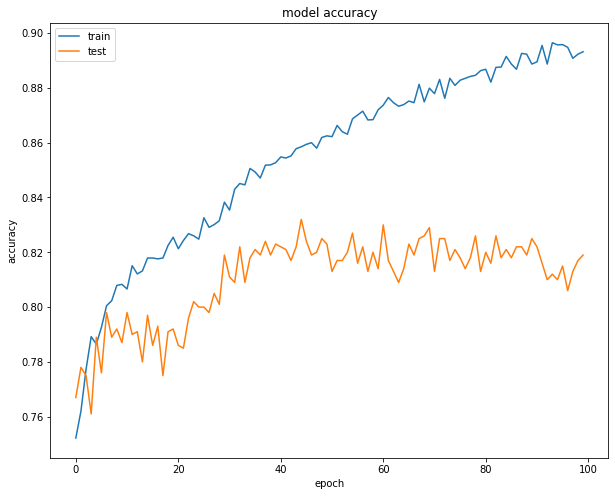

In [97]:
plt.figure(figsize = (10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')

Around 40 epoch, the model stops improving in the test dataset.

In [100]:
predict_results = model.predict(([story_test, question_test]))

In [102]:
predict_results.shape

(1000, 38)

In [103]:
predict_results[0]

array([3.1114348e-21, 3.0361022e-21, 2.7092697e-21, 2.9815499e-21,
       2.7611986e-21, 3.0801048e-21, 3.5495766e-21, 3.1811282e-21,
       2.6703511e-21, 2.9799466e-21, 2.6817436e-21, 3.0114984e-21,
       3.0604400e-21, 2.4145511e-21, 3.7570604e-21, 3.5293644e-21,
       3.5880357e-21, 2.6111208e-21, 2.5909787e-21, 3.0797522e-21,
       2.8142516e-21, 3.1423523e-21, 2.7357630e-21, 2.9665292e-21,
       4.4225611e-21, 3.2990790e-21, 2.8138974e-21, 2.0973742e-21,
       3.2945392e-21, 3.5192807e-21, 2.9930711e-21, 2.2022763e-21,
       4.3552085e-21, 2.6201107e-21, 9.9998569e-01, 1.4363315e-05,
       3.3274156e-21, 2.7349283e-21], dtype=float32)

The predict_result for each test data is a vector of probabilities of all the vocabs 

In [106]:
# convert to prediction to yes/no for the first question
val_max = np.argmax(predict_results[0])
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [108]:
print(' '.join(test_data[0][0]))
print(' '.join(test_data[0][1]))
print('The model predict the answer to be:', k, ', ', 'with probability of', predict_results[0][val_max])

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
The model predict the answer to be: no ,  with probability of 0.9999857


In [109]:
# write your own story and question and have the model to predict it, note that the model only recognize words in the vocab
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [110]:
# create a story and question in the same format as in the train set
my_story = 'Daniel dropped the apple . Sandra picked up the apple .'
my_question = 'Is Sandra in the kitchen ?'
new_data = [(my_story.split(), my_question.split(), 'yes')]
my_story, my_question, my_answer = vectorize_stories(new_data)

In [115]:
new_pred = model.predict(([my_story, my_question]))
val_max = np.argmax(new_pred)
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [116]:
k # the model make the correct prediction

'yes'

In [124]:
new_pred[0][val_max] # the probability of the prediction

0.8286194